<a href="https://colab.research.google.com/github/AroojArifNU/DLTest/blob/main/Colab_Notebooks/MNIST_GRAPH_Plot_2_properties_Abstarxct_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load Model and Select Correct Examples**

In [143]:
import numpy as np
import tensorflow as tf
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Load your trained model
print("Loading model...")
model = load_model('/content/drive/MyDrive/ColabNotebooks/mnist_model.h5')

# Load and preprocess the examples
print("Loading data...")
correct_examples = np.load('/content/drive/MyDrive/ColabNotebooks/correct_examples.npy')
correct_labels = np.load('/content/drive/MyDrive/ColabNotebooks/correct_labels.npy').astype('int32')

# Calculate accuracy on clean data
predictions = model.predict(correct_examples).argmax(axis=-1)
accuracy_clean = np.mean(predictions == correct_labels)
print(f"Accuracy on clean data: {accuracy_clean * 100:.2f}%")

# Count the occurrences of each label in the test set
# Use numpy's unique function to find unique elements in the correct_labels array and their counts
unique, counts = np.unique(correct_labels, return_counts=True)

# Zip the unique labels and their counts into a dictionary for easy access and readability
correct_labels_counts = dict(zip(unique, counts))

# Print the occurrences of each label to the console, showing how many times each label appears
print("occurrences of each label:", correct_labels_counts)

for label, count in correct_labels_counts.items():
    print(f"Label {label}: {count}")

Loading model...
Loading data...
308/308 [==============================] - 2s 5ms/step
Accuracy on clean data: 99.60%
occurrences of each label: {0: 973, 1: 1133, 2: 1016, 3: 989, 4: 969, 5: 882, 6: 937, 7: 1005, 8: 946, 9: 984}
Label 0: 973
Label 1: 1133
Label 2: 1016
Label 3: 989
Label 4: 969
Label 5: 882
Label 6: 937
Label 7: 1005
Label 8: 946
Label 9: 984



# **Select 250 samples in total at random and allocate them across classes 0 through 9.**

In [144]:
# Select a subset for demonstration


# Randomly select 250 unique indices from the range of the length of the correct_examples array without replacement
subset_indices = np.random.choice(range(len(correct_examples)), size=100, replace=False) #The parameter replace=False in the context of np.random.choice function means that once an item is selected from the array (or range) for inclusion in the sample, it cannot be selected again. This ensures that all elements in the resulting sample are unique, thereby preventing any duplicates. Essentially, it guarantees that the sampling is done without replacement.

# Use the selected indices to create a subset of images from the correct_examples array
subset_images = correct_examples[subset_indices]

# Similarly, use the selected indices to create a corresponding subset of labels from the correct_labels array
subset_labels = correct_labels[subset_indices]


In [145]:
# Use numpy's unique function to find all unique elements in the subset_labels array and count their occurrences
unique, counts = np.unique(subset_labels, return_counts=True)

# Combine the unique labels and their corresponding counts into a dictionary for easier access
subset_labels_counts = dict(zip(unique, counts))

# Print the dictionary containing the occurrences of each label in the subset
print("occurrences of each label:", subset_labels_counts)

# Iterate over the dictionary items (label and count pairs)
for label, count in subset_labels_counts.items():
    # Print each label and its count in a formatted string
    print(f"Label {label}: {count}")


occurrences of each label: {0: 9, 1: 10, 2: 10, 3: 10, 4: 12, 5: 8, 6: 6, 7: 9, 8: 17, 9: 9}
Label 0: 9
Label 1: 10
Label 2: 10
Label 3: 10
Label 4: 12
Label 5: 8
Label 6: 6
Label 7: 9
Label 8: 17
Label 9: 9


# **Automated Image Classification and Confidence Analysis**

In [146]:
class ImageTransformer:
    def __init__(self, model):
        self.model = model

    def rotate_image(self, image, degrees):
        return tf.image.rot90(image, k=degrees // 90)

    def adjust_brightness(self, image, delta):
        return tf.image.adjust_brightness(image, delta)

    def predict_with_confidence(self, images, actual_labels):
        predictions = self.model.predict(images)
        print("\n predictions:", predictions)

        # Confidence scores for predicted classes
        confidence_scores_predicted = np.max(predictions, axis=1)
        print("\n confidence_scores_predicted:", confidence_scores_predicted)

        # Predicted classes
        predicted_classes = np.argmax(predictions, axis=1)
        print("\n predicted_classes:", predicted_classes)

        # Confidence scores for actual classes if actual_labels are provided
        confidence_scores_actual = None
        if actual_labels is not None:
            confidence_scores_actual = predictions[np.arange(len(actual_labels)), actual_labels]
            print("\n confidence_scores_actual:", confidence_scores_actual)

        return confidence_scores_predicted, predicted_classes, confidence_scores_actual


In [147]:
from tabulate import tabulate

class RobustnessEvaluator:
    def __init__(self, transformer):
        self.transformer = transformer
        self.sample_details = []

    def apply_transformation_and_predict(self, images, actual_labels, transformation_func, **kwargs):
        # Apply transformation with correct keyword arguments
        if transformation_func.__name__ == 'rotate_image':
            transformed_images = [transformation_func(image, degrees=kwargs['degrees']) for image in images]
        elif transformation_func.__name__ == 'adjust_brightness':
            transformed_images = [transformation_func(image, delta=kwargs['delta']) for image in images]
        else:
            raise ValueError("Unsupported transformation function.")

        transformed_images = np.array(transformed_images)
        confidence_scores, predicted_classes,confidence_scores_actual = self.transformer.predict_with_confidence(transformed_images,actual_labels)
        return confidence_scores, predicted_classes, actual_labels,confidence_scores_actual



    def evaluate(self, images, labels, properties):
        for prop_name, settings in properties.items():
            for setting in settings:
                # Directly reference the correct transformation function and settings
                if prop_name == 'rotate_image':
                    kwargs = {'degrees': setting}
                    transformation_func = self.transformer.rotate_image
                elif prop_name == 'adjust_brightness':
                    kwargs = {'delta': setting}
                    transformation_func = self.transformer.adjust_brightness
                else:
                    continue  # Skip if the property name doesn't match expected functions

                confidence_scores, predicted_classes, actual_labels,confidence_scores_actual = self.apply_transformation_and_predict(images, labels, transformation_func, **kwargs)

                for i, image in enumerate(images):
                          self.sample_details.append({
                              'Property': prop_name,
                              'Setting': setting,
                              'Sample Index': i,
                              'Actual Label': labels[i],
                              'CS Actual Class':confidence_scores_actual[i],
                              'Predicted Class': predicted_classes[i],
                              'Confidence Score': confidence_scores[i]

                          })



    def display_results(self):
        # Convert sample details to DataFrame for display
        detailed_df = pd.DataFrame(self.sample_details)

        # Display sample-wise confidence, predicted, and actual class
        print("Detailed Sample-wise Results:")
        display(detailed_df)

        # Aggregate and display class-wise confidence
        class_wise_df = detailed_df.groupby(['Property', 'Actual Label']).agg({'CS Actual Class': 'mean'}).reset_index()
        print("\nClass-wise Confidence:")
        display(class_wise_df)

        # Display property-wise confidence and combined confidence
        prop_wise_df = detailed_df.groupby('Property').agg({'CS Actual Class': 'mean'}).reset_index()
        prop_wise_df.loc[len(prop_wise_df.index)] = ['Combined', np.prod(prop_wise_df['CS Actual Class'])]
        print("\nProperty-wise and Combined Confidence:")
        display(prop_wise_df)


    def display_detailed_sample_table(self):
        # Convert sample details to DataFrame
        detailed_df = pd.DataFrame(self.sample_details)
        return detailed_df

    def display_class_wise_confidence(self):
        # Aggregate and display class-wise confidence
        detailed_df = pd.DataFrame(self.sample_details)

        class_wise_df = detailed_df.groupby(['Property', 'Actual Label']).agg({'CS Actual Class': 'mean'}).reset_index()
        print("\nClass-wise Confidence:")


        return class_wise_df

    def display_combined_confidence(self):
        # Display property-wise confidence and combined confidence
        detailed_df = pd.DataFrame(self.sample_details)

        prop_wise_df = detailed_df.groupby('Property').agg({'CS Actual Class': 'mean'}).reset_index()
        prop_wise_df.loc[len(prop_wise_df.index)] = ['Combined', np.prod(prop_wise_df['CS Actual Class'])]

        # Calculate combined confidence
        combined_confidence = prop_wise_df['CS Actual Class'].product()
        prop_wise_df.loc[len(prop_wise_df.index)] = ['Combined', combined_confidence]
        return prop_wise_df



In [112]:
import pandas as pd

# Set display options
pd.set_option('display.max_rows', None)  # Replace None with a specific number if needed
pd.set_option('display.max_columns', None)  # Replace None with a specific number if needed
pd.set_option('display.width', 1000)  # Adjust the width to fit your display
pd.set_option('display.max_colwidth', None)  # Adjust column width for better visibility


In [148]:
# Define properties and settings for evaluation
properties = {
    'rotate_image': [90],  # Degrees
    'adjust_brightness': [0.4]  # Delta
}



# Load your pre-trained model
model = load_model('/content/drive/MyDrive/ColabNotebooks/mnist_model.h5')
transformer = ImageTransformer(model)
evaluator = RobustnessEvaluator(transformer)


# Assuming subset_images and subset_labels are defined
evaluator.evaluate(subset_images, subset_labels, properties)
evaluator.display_results()



4/4 [==============================] - 0s 6ms/step

 predictions: [[1.41289784e-02 1.36536328e-05 4.84990505e-06 1.69166549e-06
  5.22814631e-01 1.27223620e-05 1.05133246e-07 4.26869839e-01
  6.97065188e-05 3.60838063e-02]
 [6.98946940e-04 3.55836237e-05 5.47217205e-05 1.72855958e-04
  2.58588639e-09 9.72317696e-01 1.10778124e-08 2.60855556e-02
  4.75043023e-04 1.59524338e-04]
 [9.92021322e-01 2.96175829e-04 5.55690750e-03 1.62068147e-07
  2.23803836e-05 1.10364351e-09 2.68514611e-09 1.16307393e-03
  1.27963006e-07 9.39745165e-04]
 [8.66915889e-06 2.46238917e-01 1.02638642e-05 2.18169112e-03
  1.90000043e-10 1.62283599e-01 3.06746273e-09 5.79508960e-01
  8.63865204e-03 1.12929486e-03]
 [8.43635760e-04 1.01681455e-10 6.88158419e-10 8.11098016e-06
  1.61919882e-08 9.84821379e-01 5.19839782e-10 1.64332341e-05
  4.53074608e-05 1.42651871e-02]
 [7.87885547e-01 4.52168436e-09 2.05284996e-05 2.70281902e-07
  1.97820100e-06 1.99531496e-01 1.28904821e-06 1.03460206e-05
  6.21690197e-05 1.248637

,Property,Setting,Sample Index,Actual Label,CS Actual Class,Predicted Class,Confidence Score
0,rotate_image,90.0,0,2,4.849905e-06,4,0.522815
1,rotate_image,90.0,1,4,2.585886e-09,5,0.972318
2,rotate_image,90.0,2,2,5.556908e-03,0,0.992021
3,rotate_image,90.0,3,4,1.900000e-10,7,0.579509
4,rotate_image,90.0,4,9,1.426519e-02,5,0.984821
5,rotate_image,90.0,5,9,1.248637e-02,0,0.787886
6,rotate_image,90.0,6,3,1.510221e-13,4,0.906688
7,rotate_image,90.0,7,7,4.631463e-03,0,0.635942
8,rotate_image,90.0,8,0,9.998622e-01,0,0.999862
9,rotate_image,90.0,9,3,1.798643e-10,0,0.999916



Class-wise Confidence:


,Property,Actual Label,CS Actual Class
0,adjust_brightness,0,9.998600e-01
1,adjust_brightness,1,8.553426e-01
2,adjust_brightness,2,8.962672e-01
3,adjust_brightness,3,9.642159e-01
4,adjust_brightness,4,8.021140e-01
5,adjust_brightness,5,5.053328e-01
6,adjust_brightness,6,9.989166e-01
7,adjust_brightness,7,6.792122e-01
8,adjust_brightness,8,9.999366e-01
9,adjust_brightness,9,9.836769e-01



Property-wise and Combined Confidence:


,Property,CS Actual Class
0,adjust_brightness,0.877834
1,rotate_image,0.104457
2,Combined,0.091696


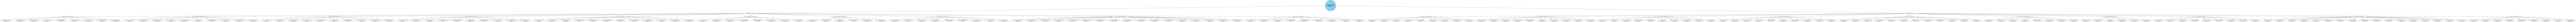

In [149]:
import pydot
from IPython.display import Image
import pandas as pd
import numpy as np

def generate_dynamic_tree(robustness_evaluator):
    # Convert sample details to DataFrame for easier processing
    detailed_df = pd.DataFrame(robustness_evaluator.sample_details)

    # Create the graph
    graph = pydot.Dot(graph_type='digraph', rankdir='TB')
    # Initialize Overall Robustness node
    overall_robustness_node = pydot.Node(
        "Overall Robustness",
        label="Global Robustness",
        shape='circle',
        style="filled",
        fillcolor="skyblue",
        fontsize='20'  # Adjust font size as needed
    )

    graph.add_node(overall_robustness_node)

    # Aggregate confidence scores by property and calculate combined confidence
    property_confidence = detailed_df.groupby('Property')['CS Actual Class'].mean().reset_index()
    combined_confidence = property_confidence['CS Actual Class'].prod()

    # Update Overall Robustness node label with combined confidence
    overall_robustness_label = f"Global Robustness\nConfidence: {combined_confidence:.3f}"
    overall_robustness_node.set_label(overall_robustness_label)

    # Process each property
    for property_name, prop_df in detailed_df.groupby('Property'):
        prop_mean_confidence = prop_df['CS Actual Class'].mean()
        prop_node_label = f"{property_name} (Confidence: {prop_mean_confidence:.2f})"
        prop_node = pydot.Node(prop_node_label, shape='ellipse', style="filled", fillcolor="lightgreen")
        # graph.add_node(prop_node)
        graph.add_edge(pydot.Edge("Overall Robustness", prop_node_label))

        # Process each class within the property
        for class_label, class_df in prop_df.groupby('Actual Label'):
            class_mean_confidence = class_df['CS Actual Class'].mean()
            class_node_label = f"Class {class_label} ({property_name}) (Confidence: {class_mean_confidence:.2f})"
            class_node = pydot.Node(class_node_label, label=f"Class {class_label} (Confidence: {class_mean_confidence:.2f})", shape='circle', style="filled", fillcolor="lightyellow")
            # graph.add_node(class_node)
            graph.add_edge(pydot.Edge(prop_node_label, class_node_label))

            # Add individual sample nodes under each class, with detail on their interaction or property
            for _, sample in class_df.iterrows():
                sample_node_label = f"Sample {sample['Sample Index']} ({class_label}, {property_name})\nConfidence: {sample['CS Actual Class']:.2f}"
                sample_node = pydot.Node(sample_node_label, shape='box', style="filled", fillcolor="lightgrey")
                # graph.add_node(sample_node)
                graph.add_edge(pydot.Edge(class_node_label, sample_node_label))

    # Generate and save the graph to a file
    output_file = 'dynamic_decision_tree_refined.png'
    graph.write_png(output_file)

    # Display the graph
    return Image(output_file)

# Assuming 'evaluator' is your instance of RobustnessEvaluator with evaluations completed
image = generate_dynamic_tree(evaluator)
display(image)


In [129]:
!pip install networkx pyvis


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.8 MB/s eta 0:00:00


In [168]:
import networkx as nx
from pyvis.network import Network
import pandas as pd
import numpy as np
from IPython.display import FileLink


def create_interactive_tree(robustness_evaluator):
    detailed_df = pd.DataFrame(robustness_evaluator.sample_details)

    # Create a networkx graph
    G = nx.DiGraph()

    # Add overall robustness node
    overall_robustness_id = "Overall Robustness"
    G.add_node(overall_robustness_id, label="Global Robustness", shape='circle', color="skyblue")

    # Aggregate confidence scores by property and calculate combined confidence
    property_confidence = detailed_df.groupby('Property')['CS Actual Class'].mean().reset_index()
    combined_confidence = property_confidence['CS Actual Class'].prod()

    # Update Overall Robustness node label with combined confidence
    G.nodes[overall_robustness_id]['label'] = f"Global Robustness\nConfidence: {combined_confidence:.3f}"

    # Add property and class nodes to the graph
    for property_name, prop_df in detailed_df.groupby('Property'):
        prop_mean_confidence = prop_df['CS Actual Class'].mean()
        prop_node_id = f"{property_name}"
        G.add_node(prop_node_id, label=f"{property_name} (Confidence: {prop_mean_confidence:.2f})", color="lightgreen")
        G.add_edge(overall_robustness_id, prop_node_id)

        for class_label, class_df in prop_df.groupby('Actual Label'):
            class_mean_confidence = class_df['CS Actual Class'].mean()
            class_node_id = f"Class {class_label} ({property_name})"
            G.add_node(class_node_id, label=f"Class {class_label} (Confidence: {class_mean_confidence:.2f})", color="yellow")
            G.add_edge(prop_node_id, class_node_id)

            for i, sample in class_df.iterrows():
                sample_node_id = f"Sample {sample['Sample Index']} ({class_label}, {property_name})"
                G.add_node(sample_node_id, label=f"S{sample['Sample Index']} (Confidence: {sample['CS Actual Class']:.2f})", color="grey")
                G.add_edge(class_node_id, sample_node_id)

    # Convert to a pyvis network and show


    net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white", cdn_resources='in_line')

    net.from_nx(G)
    # Save to a file

    # Save the interactive tree to an HTML file
    output_filepath = 'robustness_tree.html'
    net.save_graph('robustness_tree.html')


    return output_filepath

# Assuming 'evaluator' is your instance of RobustnessEvaluator with evaluations completed
# evaluator = RobustnessEvaluator(...)
# Fill in your RobustnessEvaluator code with the actual logic and data

# Create the interactive visualization
interactive_tree = create_interactive_tree(evaluator)
display(FileLink(interactive_tree))



/content/robustness_tree.html

In [169]:
from IPython.display import IFrame

# Assuming the HTML file is saved in the current directory of the Jupyter notebook
IFrame(src='robustness_tree.html', width=700, height=600)
